Init train dataset with 3875 PNEUMONIA images and 1341 NORMAL images.
Init test dataset with 390 PNEUMONIA images and 234 NORMAL images.


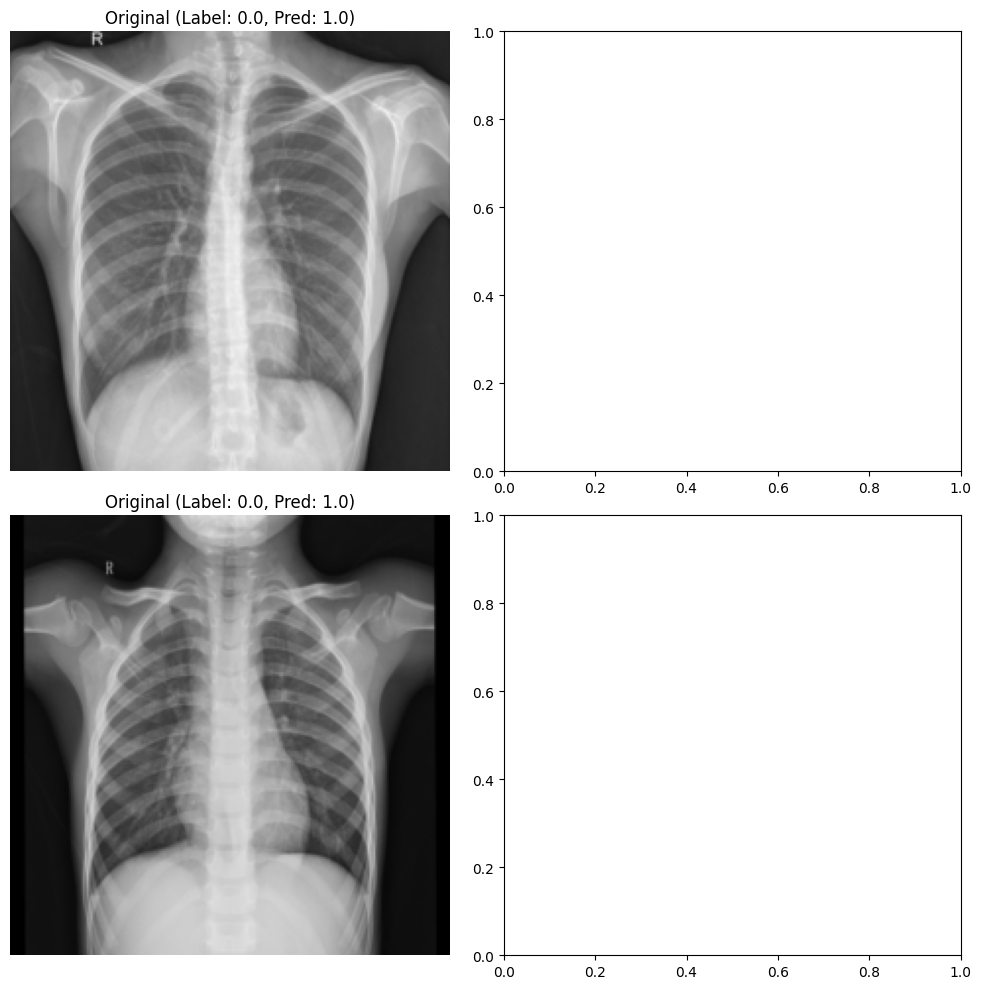

In [20]:
import datamodule
import models
import saliency
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils import BaseConfig
import torch

reload(datamodule)
reload(models)
reload(saliency)

PATH_TO_CKPT = "/home/brimax/repos/medimg-saliency-benchmark/medimg-saliency-benchmark/checkpoints/vgg_False_False_0.68.ckpt"
ALPHA = 0.3
N = 2  # Number of images to sample
device = "cuda" if torch.cuda.is_available() else "cpu"

def overlay_gradcam_on_image(img_tensor, cam, alpha=0.5):
    # img_tensor: shape [1, 3, H, W] (unnormalized, float [0,1])
    img_np = img_tensor.squeeze(0).detach().cpu().numpy()  # [3, H, W]
    img_np = np.transpose(img_np, (1, 2, 0))      # [H, W, 3]
    img_np = (img_np * 255).astype(np.uint8)

    # Resize cam to match image size
    cam_resized = cv2.resize(cam, (img_np.shape[1], img_np.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Blend heatmap with original image
    overlay = cv2.addWeighted(img_np, 1 - alpha, heatmap, alpha, 0)
    return overlay

config = BaseConfig("./config.json")
dm = datamodule.Datamodule(config)
dm.setup()
dl = dm.test_dataloader()

# Sample N random indices
indices = np.random.choice(len(dm.test_ds), N, replace=False)
indices = np.arange(0, 0+N)
# Fetch the corresponding batch of images
images = []
labels = []
for idx in indices:
    X, y = dm.test_ds[idx]
    images.append(X)
    labels.append(y)

# Convert lists to tensors
X = torch.stack(images).to(device)
y = torch.tensor(labels).to(device)

model = models.BaseCNN.load_from_checkpoint(PATH_TO_CKPT).to(device)
model.eval()
pred = model.predict(X)

# gcam = saliency.GradCAM(model.model)
# cams = []
# model.to(device)
# gcam = saliency.GradCAM(model.model)
# for i in range(N):
#     single_cam = gcam(X[[i]])  # Add batch dimension with X[[i]]
#     cams.append(single_cam)
# Plotting
fig, axes = plt.subplots(N, 2, figsize=(10, 5*N))  # Adjust figure size as needed

for i in range(N):
    # Original Image
    img = X[i].permute(1, 2, 0).cpu().numpy()
    img = (img * 255).astype(np.uint8)
    axes[i, 0].imshow(img)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"Original (Label: {y[i].item()}, Pred: {pred[i].item()})")

    # GradCAM Overlay
    # overlay = overlay_gradcam_on_image(X[i:i+1], cams[i], alpha=ALPHA)
    # axes[i, 1].imshow(overlay)
    # axes[i, 1].axis('off')
    # axes[i, 1].set_title(f"GradCAM (Pred: {pred[i].item()})")

plt.tight_layout()
plt.show()

In [14]:
# Parse the results to write in a nice latex table
import json
import os

# Parse the JSON file
def parse_json_and_format_for_latex(json_data):
    # Load the JSON data
    data = json_data
    
    # Extract the results
    results = data["results"][0]
    
    # Format the metrics with confidence intervals
    # We'll round to 3 decimal places and format as "mean ± half_width"
    metrics = {}
    
    # Calculate and format each metric
    metrics["accuracy"] = f"{results['test/accuracy_mean']:.3f},{(results['test/accuracy_ci_upper'] - results['test/accuracy_ci_lower'])/2:.3f}"
    metrics["precision"] = f"{results['test/precision_mean']:.3f},{(results['test/precision_ci_upper'] - results['test/precision_ci_lower'])/2:.3f}"
    metrics["recall"] = f"{results['test/recall_mean']:.3f},{(results['test/recall_ci_upper'] - results['test/recall_ci_lower'])/2:.3f}"
    metrics["f1"] = f"{results['test/f1_mean']:.3f},{(results['test/f1_ci_upper'] - results['test/f1_ci_lower'])/2:.3f}"
    metrics["auroc"] = f"{results['test/auroc_mean']:.3f},{(results['test/auroc_ci_upper'] - results['test/auroc_ci_lower'])/2:.3f}"
    
    # Print the formatted metrics for LaTeX table
    # print("Formatted metrics for LaTeX table:")
    # print(f"Accuracy: {metrics['accuracy']}")
    # print(f"Precision: {metrics['precision']}")
    # print(f"Recall: {metrics['recall']}")
    # print(f"ROC AUC: {metrics['auroc']}")
    
    # Return the metrics dictionary
    return metrics

for evals in os.listdir("evaluation"):
    # print()
    model, linear, pretrained = evals.split("_")[:3]

    with open(f"evaluation/{evals}", "r") as f:
        res = json.load(f)
    metrics = parse_json_and_format_for_latex(res)
    with open("tmp.txt", "a") as f:
        f.write(f"{model},{linear},{pretrained},{metrics['accuracy']},{metrics['precision']},{metrics['recall']},{metrics['f1']},{metrics['auroc']}\n")

In [24]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Parse the JSON file and extract metrics with confidence intervals
def parse_json_and_extract_metrics(json_data):
    # Load the JSON data
    data = json_data
    
    # Extract the results
    results = data["results"][0]
    
    # Store mean values and confidence intervals
    metrics = {}
    
    # Calculate mean and half width of confidence interval for each metric
    metrics["accuracy"] = {
        "mean": results['test/accuracy_mean'],
        "ci_half": (results['test/accuracy_ci_upper'] - results['test/accuracy_ci_lower'])/2
    }
    metrics["precision"] = {
        "mean": results['test/precision_mean'],
        "ci_half": (results['test/precision_ci_upper'] - results['test/precision_ci_lower'])/2
    }
    metrics["recall"] = {
        "mean": results['test/recall_mean'],
        "ci_half": (results['test/recall_ci_upper'] - results['test/recall_ci_lower'])/2
    }
    metrics["f1"] = {
        "mean": results['test/f1_mean'],
        "ci_half": (results['test/f1_ci_upper'] - results['test/f1_ci_lower'])/2
    }
    metrics["auroc"] = {
        "mean": results['test/auroc_mean'],
        "ci_half": (results['test/auroc_ci_upper'] - results['test/auroc_ci_lower'])/2
    }
    
    return metrics

# Process all evaluation files and store results in a DataFrame
def process_evaluation_files(eval_dir="evaluation"):
    data = []
    
    for evals in os.listdir(eval_dir):
        model, linear, pretrained = evals.split("_")[:3]
        
        with open(f"{eval_dir}/{evals}", "r") as f:
            res = json.load(f)
        
        metrics = parse_json_and_extract_metrics(res)
        
        # Create a row for this model
        row = {
            'model': model,
            'linear': linear,
            'pretrained': pretrained,
            'model_name': f"{model}_{linear}_{pretrained}"
        }
        
        # Add all metrics to the row
        for metric_name, metric_values in metrics.items():
            row[f"{metric_name}_mean"] = metric_values["mean"]
            row[f"{metric_name}_ci_half"] = metric_values["ci_half"]
        
        data.append(row)
    
    return pd.DataFrame(data)

# Create bar plots with confidence intervals for each metric
def plot_metrics(df):
    # List of metrics to plot
    metrics = ["accuracy", "precision", "recall", "f1", "auroc"]
    
    # Set up the figure size and style
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['figure.figsize'] = (15, 10)
    
    for metric in metrics:
        plt.figure()
        
        # Prepare data for plotting
        model_names = df['model_name']
        means = df[f'{metric}_mean']
        errors = df[f'{metric}_ci_half']
        
        # Create bar plot with error bars
        plt.bar(model_names, means, yerr=errors, capsize=10, color='skyblue', edgecolor='black')
        
        # Customize the plot
        plt.title(f'{metric.upper()} with 95% Confidence Intervals', fontsize=16)
        plt.xlabel('Models', fontsize=14)
        plt.ylabel(f'{metric.capitalize()}', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
        # Add grid for better readability
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Save the figure
        plt.savefig(f'plots/{metric}_barplot.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    print(f"Generated plots for {', '.join(metrics)}")

# Alternative: Create a single plot with all metrics using seaborn
def plot_all_metrics_together(df):
    # Melt the DataFrame to have metrics as a categorical variable
    metrics_cols = ['accuracy_mean', 'precision_mean', 'recall_mean', 'f1_mean', 'auroc_mean']
    ci_cols = ['accuracy_ci_half', 'precision_ci_half', 'recall_ci_half', 'f1_ci_half', 'auroc_ci_half']
    
    # Create a long-form dataframe for seaborn
    melted_df = pd.melt(df, id_vars=['model_name'], 
                        value_vars=metrics_cols,
                        var_name='metric', value_name='value')
    
    # Add CI information
    melted_df['metric_base'] = melted_df['metric'].str.replace('_mean', '')
    melted_ci = pd.melt(df, id_vars=['model_name'], 
                       value_vars=ci_cols,
                       var_name='ci_metric', value_name='ci')
    melted_ci['metric_base'] = melted_ci['ci_metric'].str.replace('_ci_half', '')
    
    # Merge the dataframes
    final_df = pd.merge(melted_df, melted_ci, on=['model_name', 'metric_base'])
    
    # Clean up the metric names for display
    final_df['clean_metric'] = final_df['metric'].str.replace('_mean', '').str.capitalize()
    
    # Create the plot
    plt.figure(figsize=(18, 10))
    
    # Plot grouped bar chart
    ax = sns.barplot(x='clean_metric', y='value', hue='model_name', data=final_df)
    
    # Add error bars
    x_coords = np.arange(len(final_df['clean_metric'].unique()))
    width = 0.8 / len(df['model_name'].unique())
    
    for i, model in enumerate(df['model_name'].unique()):
        model_data = final_df[final_df['model_name'] == model]
        x_pos = x_coords - 0.4 + width * (i + 0.5)
        plt.errorbar(x=x_pos, y=model_data['value'], yerr=model_data['ci'], 
                    fmt='none', capsize=5, ecolor='black', alpha=0.75)
    
    # Customize plot
    plt.title('Performance Metrics Comparison', fontsize=16)
    plt.xlabel('Metric', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    # Save figure
    plt.savefig('plots/all_metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print("Generated combined metrics plot")

# Example of how to run the code
if __name__ == "__main__":
    # Example usage with demonstration data
    # If you're testing without actual files, you can uncomment this block:
    """
    # Create sample data
    sample_data = []
    models = ['AlexNet', 'ResNet', 'VGG', 'InceptionNet']
    
    for model in models:
        # Create a mock data entry for each model
        row = {
            'model': model,
            'linear': 'linear',
            'pretrained': 'true',
            'model_name': model,
            'accuracy_mean': np.random.uniform(0.7, 0.9),
            'accuracy_ci_half': np.random.uniform(0.01, 0.03),
            'precision_mean': np.random.uniform(0.6, 0.8),
            'precision_ci_half': np.random.uniform(0.01, 0.03),
            'recall_mean': np.random.uniform(0.8, 1.0),
            'recall_ci_half': np.random.uniform(0.01, 0.03),
            'f1_mean': np.random.uniform(0.7, 0.9),
            'f1_ci_half': np.random.uniform(0.01, 0.03),
            'auroc_mean': np.random.uniform(0.7, 0.9),
            'auroc_ci_half': np.random.uniform(0.01, 0.03)
        }
        sample_data.append(row)
    
    df = pd.DataFrame(sample_data)
    """
    os.makedirs("plots", exist_ok=True)
    # Process all evaluation files
    try:
        df = process_evaluation_files()
        
        # Create individual plots for each metric
        plot_metrics(df)
        
        # Create a combined plot with all metrics
        plot_all_metrics_together(df)
        
    except FileNotFoundError:
        print("Evaluation directory not found. Please make sure the directory exists.")
        
        # For demonstration, you can use the sample data mentioned above
        print("Generating plots with sample data for demonstration...")
        
        # Create sample data
        sample_data = []
        models = ['AlexNet', 'ResNet', 'VGG', 'InceptionNet']
        
        for model in models:
            # Create a mock data entry for each model
            row = {
                'model': model,
                'linear': 'linear',
                'pretrained': 'true',
                'model_name': model,
                'accuracy_mean': np.random.uniform(0.7, 0.9),
                'accuracy_ci_half': np.random.uniform(0.01, 0.03),
                'precision_mean': np.random.uniform(0.6, 0.8),
                'precision_ci_half': np.random.uniform(0.01, 0.03),
                'recall_mean': np.random.uniform(0.8, 1.0),
                'recall_ci_half': np.random.uniform(0.01, 0.03),
                'f1_mean': np.random.uniform(0.7, 0.9),
                'f1_ci_half': np.random.uniform(0.01, 0.03),
                'auroc_mean': np.random.uniform(0.7, 0.9),
                'auroc_ci_half': np.random.uniform(0.01, 0.03)
            }
            sample_data.append(row)
        
        df = pd.DataFrame(sample_data)
        
        # Generate plots with sample data
        plot_metrics(df)
        plot_all_metrics_together(df)

Generated plots for accuracy, precision, recall, f1, auroc
Generated combined metrics plot


Init train dataset with 3875 PNEUMONIA images and 1341 NORMAL images.
Init test dataset with 390 PNEUMONIA images and 234 NORMAL images.


AlexNetBinary(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (classifier): Linear(in_features=256, out_features=1, bias=True)
)

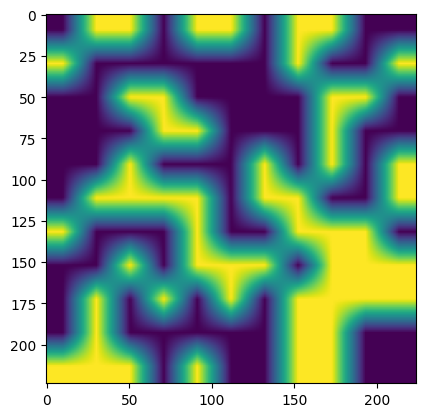

In [79]:
from datamodule import Datamodule
from utils import BaseConfig
import models
from importlib import reload
import torch
import saliency
import matplotlib.pyplot as plt
reload(models)
reload(saliency)
config = BaseConfig("config.json")
dm = Datamodule(config)
dm.setup() 
X, y = next(iter(dm.train_dataloader()))

model = models.AlexNetBinary(config)
# model = models.VGG16Binary(config)
# model = models.ResNet101Binary(config)
# model = models.InceptionNetBinary(config)
cam = saliency.RISE(model)

out = cam(X[[0]])

plt.imshow(out)
model